## YOLO Detection and Segmentation

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
# Load the segmentation model (official or custom)
model = YOLO("yolo11n-seg.pt")          # official model
# model = YOLO("path/to/best.pt")       # custom model if available

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg


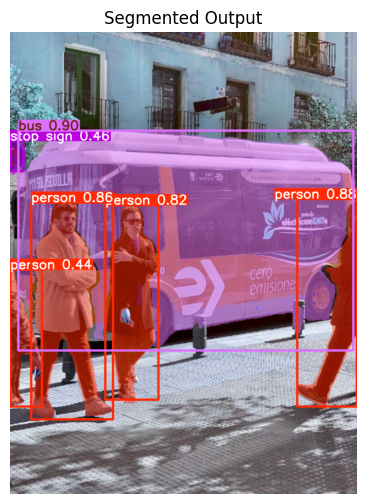

In [3]:
# Run inference on an image URL
results = model("https://ultralytics.com/images/bus.jpg", verbose=False, show=True)

# Iterate over results and plot annotated images
for result in results:
    # result.plot() returns the image with segmentation overlays (as a numpy array)
    annotated_image = result.plot()
    
    # Display image using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(annotated_image)
    plt.axis("off")  # Hide axes for clarity
    plt.title("Segmented Output")
    plt.show()


# YOLO Segmentation Area Computation


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 C:\Users\sabar\Workspace\Thesis\2D_Tracking\bus.jpg: 640x480 4 persons, 102.1ms
Speed: 3.1ms preprocess, 102.1ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 480)


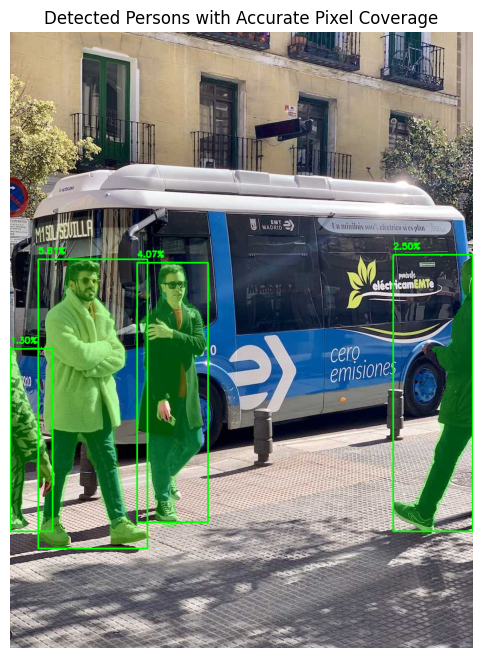

In [4]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load YOLOv8 segmentation model
model = YOLO("yolo11n-seg.pt")  # Ensure it's a segmentation model

# Run inference on an image, filtering only the person class (class 0 in COCO)
results = model("https://ultralytics.com/images/bus.jpg", classes=[0])

# Process each image result
for result in results:
    # Get original image (BGR format)
    frame = result.orig_img.copy()
    height, width = frame.shape[:2]
    image_area = height * width

    # Get bounding boxes, class IDs, and segmentation masks
    boxes   = result.boxes.xyxy.cpu().numpy().astype(int)  # [N x 4]
    classes = result.boxes.cls.cpu().numpy().astype(int)   # [N]
    masks   = result.masks.data.cpu().numpy()              # [N x Mh x Mw]

    person_percentages = []

    # Iterate through each detected person
    for i, cls in enumerate(classes):
        if cls != 0:  # Skip non-persons
            continue

        x1, y1, x2, y2 = boxes[i]
        raw_mask = masks[i].astype(np.uint8)

        # Resize mask to match original image size
        mask_resized = cv2.resize(raw_mask, (width, height), interpolation=cv2.INTER_NEAREST).astype(bool)

        # Compute percentage area
        filled_pixels = mask_resized.sum()
        percentage = (filled_pixels / image_area) * 100
        person_percentages.append(percentage)

        # Blend green overlay on the mask
        alpha, beta = 0.7, 0.3
        green = np.array([0, 255, 0], dtype=np.uint8)
        frame[mask_resized] = (
            frame[mask_resized].astype(np.float32) * alpha + green * beta
        ).astype(np.uint8)

        # Draw bounding box and percentage label
        label = f"{percentage:.2f}%"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert BGR to RGB for display
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb)
    plt.axis("off")
    plt.title("Detected Persons with Accurate Pixel Coverage")
    plt.show()


# YOLO ONNX Conversion

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.pt")  # load an official model
# model = YOLO("path/to/best.pt")  # load a custom trained model

# Export the model
# model.export(format="onnx")
model.export(format="onnx", imgsz=384, half=True, simplify=True, dynamic=False, nms=True)

Ultralytics 8.3.82  Python-3.10.14 torch-2.6.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
WARNING  half=True only compatible with GPU export, i.e. use device=0
YOLO11n-seg summary (fused): 113 layers, 2,868,664 parameters, 0 gradients, 10.4 GFLOPs

PyTorch: starting from 'yolo11n-seg.pt' with input shape (1, 3, 384, 384) BCHW and output shape(s) ((1, 300, 38), (1, 32, 96, 96)) (5.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success  2.3s, saved as 'yolo11n-seg.onnx' (11.2 MB)

Export complete (2.6s)
Results saved to C:\Users\sabar\Workspace\Thesis\2D_Tracking
Predict:         yolo predict task=segment model=yolo11n-seg.onnx imgsz=384  
Validate:        yolo val task=segment model=yolo11n-seg.onnx imgsz=384 data=/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n-seg.onnx'

Loading yolo11n-seg.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 C:\Users\sabar\Workspace\Thesis\2D_Tracking\bus.jpg: 384x384 3 persons, 1 bus, 1 truck, 57.7ms
Speed: 1.7ms preprocess, 57.7ms inference, 31.2ms postprocess per image at shape (1, 3, 384, 384)


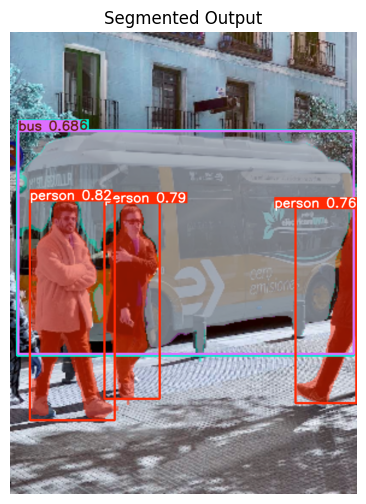

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the exported ONNX model
onnx_model = YOLO("./yolo11n-seg.onnx")

# Run inference
results = onnx_model("https://ultralytics.com/images/bus.jpg",imgsz=384)

# Iterate over results and plot annotated images
for result in results:
    # result.plot() returns the image with segmentation overlays (as a numpy array)
    annotated_image = result.plot()
    
    # Display image using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(annotated_image)
    plt.axis("off")  # Hide axes for clarity
    plt.title("Segmented Output")
    plt.show()

## YOLO Detection and Segmentation from Camera feed

In [ ]:
import cv2
from ultralytics import YOLO

# Load ONNX model (make sure it was exported with imgsz=384)
model = YOLO("yolo11n-seg.onnx")

# Open the default camera (use 1 or 2 if you have multiple)
cap = cv2.VideoCapture(0)

# Set capture resolution to match model input if needed (optional)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 384)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 384)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Run YOLO segmentation inference
    results = model(frame, imgsz=384)

    # Annotate the frame with segmentation overlays
    annotated_frame = results[0].plot()

    # Display the frame
    cv2.imshow("YOLOv8 Segmentation - Press 'q' to Quit", annotated_frame)

    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()